# Filter Example

This example demonstrates the connection between MKS and signal
processing for a 1D filter. It shows that the filter is in fact the
same as the influence coefficients and, thus, applying the `LocalizationRegressor` is in essence just applying a filter.

In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from sklearn.pipeline import Pipeline

from pymks import (
    PrimitiveTransformer,
    LocalizationRegressor,
    coeff_to_real
)

Construct a filter, $F$, such that

$$F\left(x\right) = e^{-|x|} \cos{\left(2\pi x\right)} $$

Try to show that, if $F$ is used to generate sample calibration
data for the MKS, then the calculated influence coefficients are in
fact just $F$.

In [7]:
def filter_(x):
    return np.exp(-abs(x)) * np.cos(2 * np.pi * x)

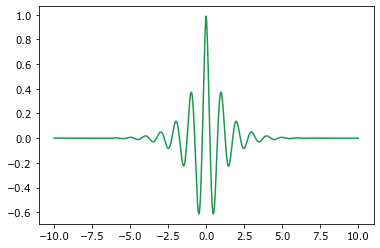

In [41]:
x = np.linspace(-10.0, 10.0, 1000)
y = filter_(x)

plt.plot(x, y, color='#1a9850');

Next, generate the sample data using
`scipy.ndimage.convolve`. This performs the convolution

$$ p\left[ s \right] = \sum_r F\left[r\right] X\left[r - s\right] $$

for each sample.

In [21]:
np.random.seed(201)

def convolve(x_sample):
    return scipy.ndimage.convolve(
        x_sample,
        filter_(np.linspace(-10.0, 10.0, len(x_sample))),
        mode="wrap"
    )

x_data = np.random.random((50, 101))

y_data = np.array([convolve(x_sample) for x_sample in x_data])

In [22]:
print(x_data.shape, y_data.shape)

(50, 101) (50, 101)


For this problem, a basis is unnecessary, as no discretization is
required in order to reproduce the convolution with the MKS localization. Using
the `PrimitiveTransformer` with `n_state=2` is the equivalent of a
non-discretized convolution in space.

In [33]:
pipeline = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2)),
    ('regressor', LocalizationRegressor())
])

pipeline.fit(x_data, y_data)
y_predict = pipeline.predict(x_data)
fcoeff = pipeline.steps[1][1].coeff

print(y_predict[0, :4].compute())
print(y_data[0, :4])
print(fcoeff.shape)

[-0.41059557  0.20004566  0.61200171  0.5878077 ]
[-0.41059557  0.20004566  0.61200171  0.5878077 ]
(101, 2)


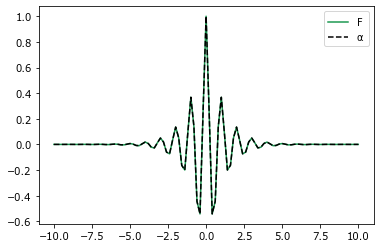

In [44]:
x = np.linspace(-10.0, 10.0, 101)
coeff = coeff_to_real(fcoeff, (101,))
plt.plot(x, filter_(x), label=r'$F$', color='#1a9850')
plt.plot(x, -coeff.real[:, 0] + coeff.real[:, 1], 
         'k--', label=r'$\alpha$')
l = plt.legend()
plt.show()

Some manipulation of the coefficients is required to reproduce the filter. Remember the convolution for the MKS is

$$ p \left[s\right] = \sum_{l=0}^{L-1} \sum_{r=0}^{S - 1} \alpha[l, r] m[l, s - r] $$

However, when the primitive basis is selected, the `MKSLocalizationModel` solves a modified form of this. There are always redundant coefficients since

$$ \sum\limits_{l=0}^{L-1} m[l, s] = 1 $$

Thus, the regression in Fourier space must be done with categorical variables, and the regression takes the following form:


$$ \begin{split}
p [s] & = \sum_{l=0}^{L - 1} \sum_{r=0}^{S - 1} \alpha[l, r] m[l, s -r] \\
P [k] & = \sum_{l=0}^{L - 1} \beta[l, k] M[l, k] \\
&= \beta[0, k] M[0, k] + \beta[1, k] M[1, k]
\end{split}
$$

where

$$\beta[0, k] = \begin{cases}
\langle F(x) \rangle ,& \text{if } k = 0\\
0,              & \text{otherwise}
\end{cases} $$

This removes the redundancies from the regression, and we can reproduce the filter.